# INTRODUCTION

# ANALYSIS

In [ ]:
# Import all libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import seaborn as sn
from collections import Counter
import re
from itertools import chain, islice
import requests
import urllib.request
from bs4 import BeautifulSoup
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import chisquare

# Linear Regression: Predicting Song Popularity

Let's see if we can use a __model a song's popularity using a linear regression model with the song's audio features as predictor variables__. Based on our intuition, we expect energy and danceability to be positively correlated with popularity, as songs with higher energy/danceability tend to be played more frequently on the radio and at parties/social gatherings.

First, we reorganize our dataset so we only have one song per row, rather than one song per row per day. Since a song's audio features don't change from day to day, we don't need to worry about changing those variables in the new dataframe. However, there are some time-dependent variables that need to be summarized in the new dataframe. They are listed below:
* __days__ = number of times the song shows up in the original dataframe
* __peak_streams__ = maximum number of times the song was streamed
* __median_streams__ = median [...]
* __peak_rank__ = highest rank the song achieved while it was on the charts
* __median_rank__ = median [...]

*There are many other summary statistics I could have used to aggregate the data -- I chose to look at the __median__ for robustness against outliers and the maximums (peaks) to get a snapshot of the exactly how popular a song became in its time in the charts.*

In [2]:
all_df = pd.read_csv("data/TopCharts.csv").dropna().reset_index(drop = True) # import data
unique_songs_df = all_df.drop_duplicates(subset = ['uri']).copy() # each song only appears once
for uri in unique_songs_df.uri:
    song_subset = all_df.loc[all_df.uri == uri, :]
    unique_songs_df.loc[unique_songs_df.uri == uri, 'days'] = len(song_subset)
    unique_songs_df.loc[unique_songs_df.uri == uri, 'peak_streams'] = song_subset.streams.max()
    unique_songs_df.loc[unique_songs_df.uri == uri, 'median_streams'] = song_subset.streams.median()
    unique_songs_df.loc[unique_songs_df.uri == uri, 'peak_rank'] = song_subset['rank'].min()
    unique_songs_df.loc[unique_songs_df.uri == uri, 'median_rank'] = song_subset['rank'].median()

unique_songs_df.drop(columns = ['streams', 'rank', 'date'], inplace = True)

In [3]:
# re-arrange order of columns
unique_songs_df = unique_songs_df[['peak_rank', 'median_rank', 'days', 'peak_streams', 'median_streams'] + list(unique_songs_df.columns[:-5].values)]

In [4]:
unique_songs_df.head() # see first five rows of dataframe

,peak_rank,median_rank,days,peak_streams,median_streams,artist,title,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature
0,1.0,71.0,429.0,1823391.0,309115.0,Migos,Bad and Boujee (feat. Lil Uzi Vert),0.927,0.665,11.0,...,1.0,0.2440,0.061,0.000000,0.123,0.175,127.076,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,343150.0,4.0
1,2.0,96.0,455.0,1428332.0,249886.0,Drake,Fake Love,0.928,0.481,9.0,...,0.0,0.2870,0.105,0.000000,0.176,0.613,134.007,spotify:track:343YBumqHu19cGoGARUTsd,210937.0,4.0
2,3.0,101.5,464.0,1134858.0,248945.0,The Weeknd,Starboy,0.679,0.587,7.0,...,1.0,0.2760,0.141,0.000006,0.137,0.486,186.003,spotify:track:7MXVkk9YMctZqd1Srtv4MB,230453.0,4.0
3,4.0,119.0,536.0,1010492.0,245003.0,The Chainsmokers,Closer,0.748,0.524,8.0,...,1.0,0.0338,0.414,0.000000,0.111,0.661,95.010,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,244960.0,4.0
4,5.0,101.0,240.0,874289.0,267720.0,Rae Sremmurd,Black Beatles,0.794,0.632,0.0,...,1.0,0.0649,0.142,0.000000,0.128,0.355,145.926,spotify:track:6fujklziTHa8uoM5OQSfIo,291893.0,4.0


Let's save this processed dataframe as a CSV file so we don't need to go through the preprocessing steps again in the future. 

In [5]:
unique_songs_df.to_csv("data/TopCharts_unique_songs.csv", index = False)  # write to CSV

Let's try to __measure popularity using the number of days a song appeared on the charts__. Here's a look:

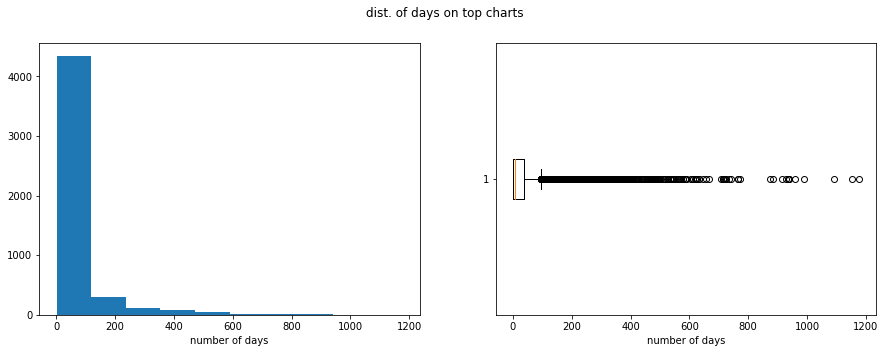

count    4899.000000
mean       48.210655
std       108.815695
min         1.000000
25%         2.000000
50%         7.000000
75%        39.000000
max      1177.000000
Name: days, dtype: float64

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # set up two separate figures and display side-by-side
ax1.hist(unique_songs_df.days)
ax1.set_xlabel("number of days")
ax1.set_ylabel("frequency of songs")
ax2.boxplot(unique_songs_df.days, vert = False)
ax2.set_xlabel("number of days")
fig.suptitle("dist. of days on charts")
plt.show()

unique_songs_df.days.describe() # summary statistics of 'days' feature

We see that the distribution of the number of days that songs appear on the charts is __extremely right skewed__, with most songs staying on the charts for fewer than 40 days. Let's log-transform the number of days to try and lessen the skew:

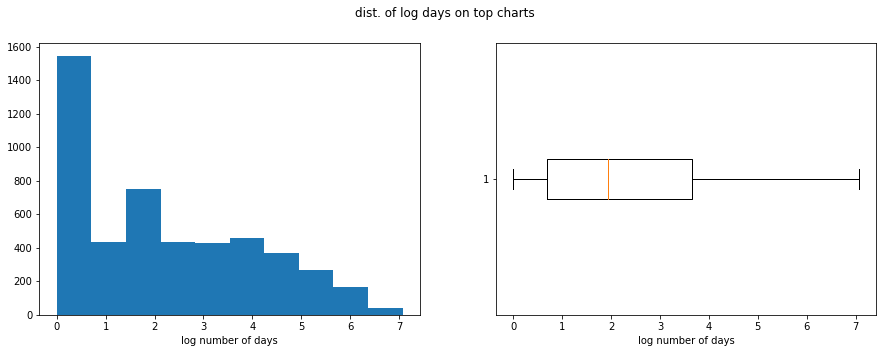

count    4899.000000
mean        2.221325
std         1.830212
min         0.000000
25%         0.693147
50%         1.945910
75%         3.663562
max         7.070724
Name: days, dtype: float64

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # set up two separate figures and display side-by-side
ax1.hist(np.log(unique_songs_df.days))
ax1.set_xlabel("log number of days")
ax2.boxplot(np.log(unique_songs_df.days), vert = False)
ax2.set_xlabel("log number of days")
fig.suptitle("dist. of log days on charts")
plt.show()

np.log(unique_songs_df.days).describe() # summary statistics of log-transformed 'days' feature

While the skew is still present, it is a lot better than before. Now, let's examine the distributions of audio features:

In [94]:
# continuous audio features
cont_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

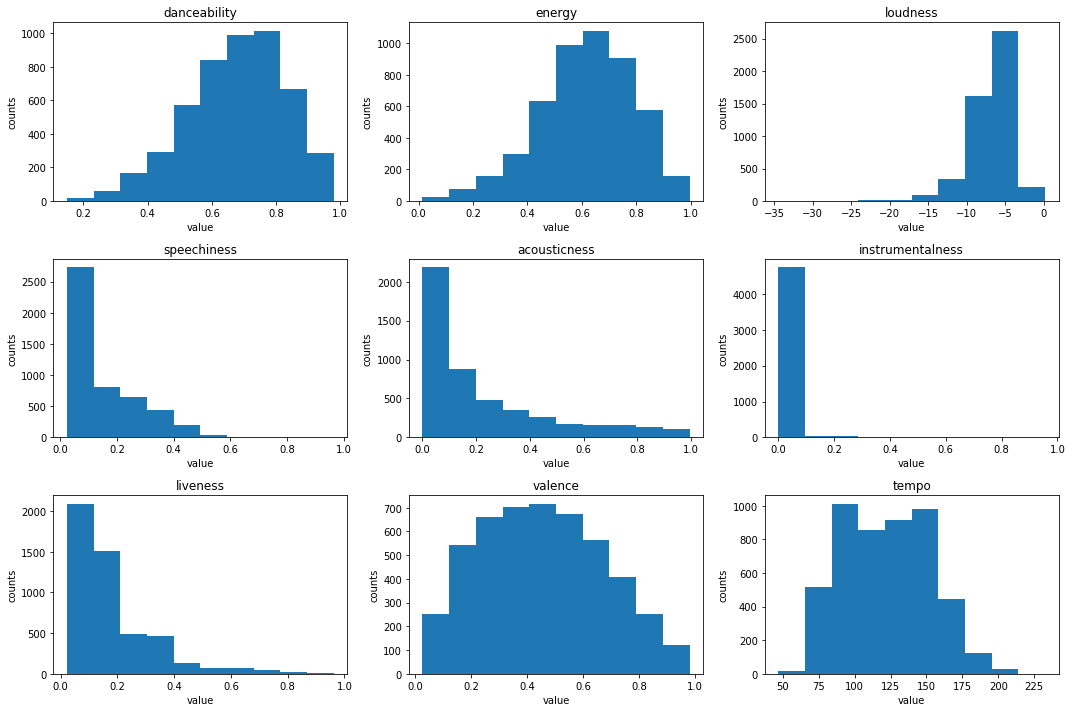

In [97]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,10)) # 3x3 grid of figures displaying distributions of audio features

for i, ax in enumerate(axes.flat):
    col = cont_cols[i]
    ax.set_title(col)
    ax.hist(unique_songs_df[col])
    ax.set_xlabel('value')
    ax.set_ylabel('counts')

fig.tight_layout()

plt.show()

We make a few observations:

* Speechiness, acousticness, and liveness are all skewed right. We can log-transform these variables to try and fix this.
* Almost every song has an instrumentalness value of ~ 0. This feature is clearly not predictive of a song's popularity -- we can drop this from our model.

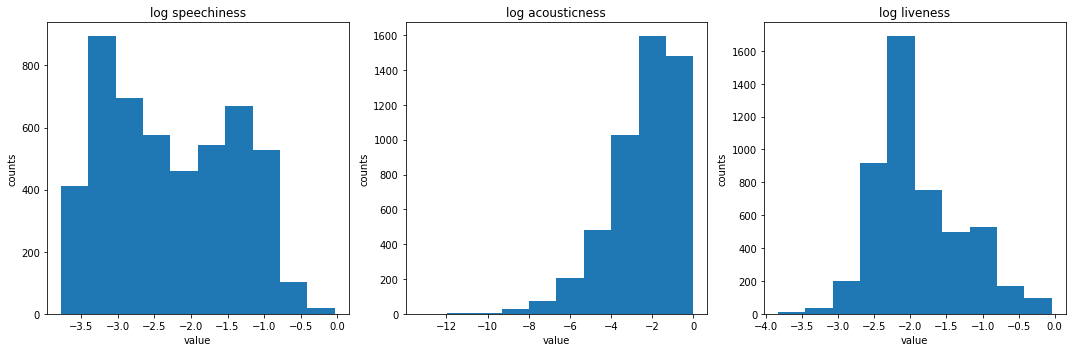

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5)) # display 3 figures
skewed_cols = ["speechiness", "acousticness", "liveness"] # aforementioned skewed-right audio features
for i, ax in enumerate(axes.flat):
    col = skewed_cols[i]
    ax.set_title("log " + col)
    ax.hist(np.log(unique_songs_df[col])) # log-transform these features
    ax.set_xlabel('value')
    ax.set_ylabel('counts')

fig.tight_layout()

plt.show()

Speechiness and liveness look a lot better than before, but even after the log transformation, acousticness is still skewed. __Let's only transform speechiness and liveness for our model__.

In [154]:
# drop 'instrumentalness' feature
cont_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness','valence', 'tempo']

In [93]:
song_lr_X = unique_songs_df[cont_cols]
song_lr_X.speechiness = unique_songs_df['speechiness'].map(lambda x: np.log(x)) # log-transform 'speechiness'
song_lr_X.liveness = unique_songs_df['liveness'].map(lambda x: np.log(x)) # log-transform 'liveness'
song_lr_X = song_lr_X.rename(columns = {'speechiness':'log_speechiness', 'liveness':'log_liveness'})
song_lr_days = np.log(unique_songs_df.days) # log-transform 'days'

In [97]:
song_days_model = LinearRegression().fit(song_lr_X, song_lr_days) # fit linear regression between our features and popularity measure
print(f"r2: {song_days_model.score(song_lr_X, song_lr_days)}")
print("coefficients:")
pp.pprint(dict(zip(song_lr_X.columns, song_days_model.coef_)))

r2: 0.031142996638798826
coefficients:
{   'acousticness': 0.04552157022358166,
    'danceability': 1.5939048604879726,
    'energy': -1.1181390912759905,
    'instrumentalness': -1.026304152975747,
    'log_liveness': -0.03704672268789331,
    'log_speechiness': -0.07457587436353365,
    'loudness': 0.07421732234216008,
    'tempo': 0.0010408181497819973,
    'valence': -0.17332904643365202}


Clearly, with an $r^2$ of ~3%, it's clear to see that __this model isn't great__; these audio features are extremely weak predictors for how many days a song stays on the charts. Let's try other measures of popularity and see how the regression models do:

Let's try __measuring popularity using peak streams__ -- peak streams represent the maximum number of streams a song was streamed in a day while it was on the charts. It follows logically that if a song is more popular, then it would be streamed more frequently.

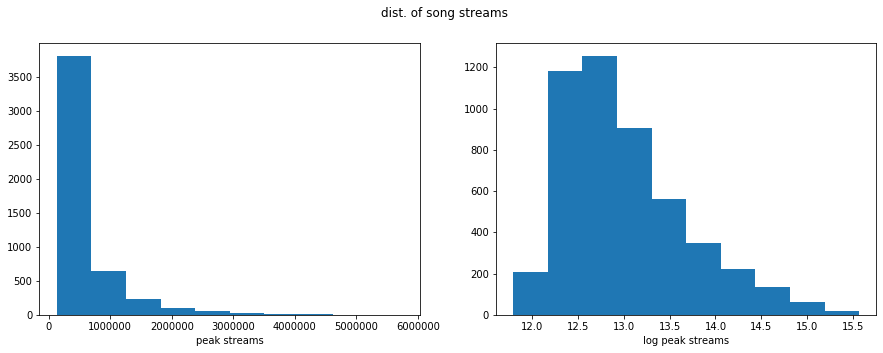

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # display side-by-side distributions of peak_streams and log(peak_streams)
ax1.hist(unique_songs_df.peak_streams)
ax1.set_xlabel("peak streams")
ax1.set_ylabel("frequency of songs")
ax2.hist(np.log(unique_songs_df.peak_streams))
ax2.set_xlabel("log peak streams")
ax2.set_ylabel("frequency of songs")
fig.suptitle("dist. of peak streams")
plt.show()

Again, the raw distribution is quite skewed, so we go with the log-transformed 'peak_streams' as our response variable.

In [98]:
song_lr_pstreams = np.log(unique_songs_df.peak_streams) # log-transformed 'peak_streams'
song_pstreams_model = LinearRegression().fit(song_lr_X, song_lr_pstreams) # fit lin. regression model
print(f"r2: {song_pstreams_model.score(song_lr_X, song_lr_pstreams)}")
print("coefficients:")
pp.pprint(dict(zip(song_lr_X.columns, song_pstreams_model.coef_)))

r2: 0.023326108389662314
coefficients:
{   'acousticness': 0.06007959548841697,
    'danceability': 0.3732393797067116,
    'energy': -0.4325464898274527,
    'instrumentalness': -0.03418540601161488,
    'log_liveness': 0.06145380457331843,
    'log_speechiness': 0.041554454783811964,
    'loudness': 0.01061803473301748,
    'tempo': 0.00041718373486746956,
    'valence': -0.04928842182999355}


__Again, our results are not great__ -- the $r^2$ in this model is actually lower than the $r^2$ in the previous model that predicted the number of days a song would stay on the charts.

So, let's again __adjust our popularity metric to median streams__ -- this is the median number of times a song was streamed while it was on the charts. Again, this metric should be a more robust and comprehensive measure of relative popularity: if a song is extremely popular one day but then fades away, that song would generally be considered to be less popular than a song that is consistently streamed a lot. 

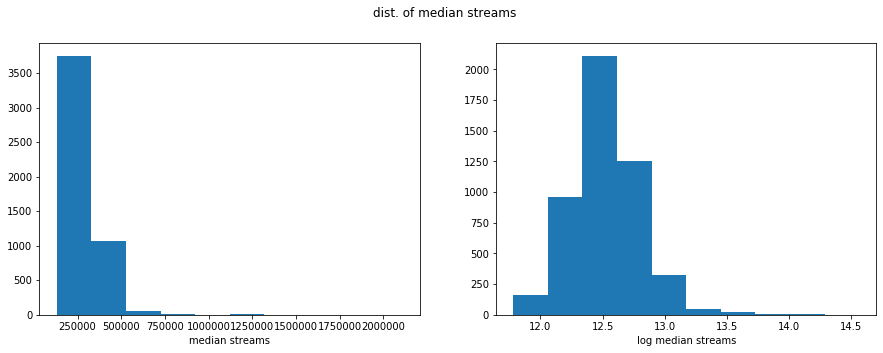

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5)) # display side-by-side distributions of median_streams and log(median_streams)
ax1.hist(unique_songs_df.median_streams)
ax1.set_xlabel("median streams")
ax1.set_ylabel("frequency of songs")
ax2.hist(np.log(unique_songs_df.median_streams))
ax2.set_xlabel("log median streams")
ax2.set_ylabel("frequency of songs")
fig.suptitle("dist. of median streams")
plt.show()

In [102]:
song_lr_mstreams = np.log(unique_songs_df.median_streams) # log-transformed 'median_streams'
song_mstreams_model = LinearRegression().fit(song_lr_X, song_lr_mstreams) # fit lin. regression model
print(f"r2: {song_mstreams_model.score(song_lr_X, song_lr_mstreams)}")
print("coefficients:")
pp.pprint(dict(zip(song_lr_X.columns, song_mstreams_model.coef_)))

r2: 0.01366628323560981
coefficients:
{   'acousticness': 0.03393711804377634,
    'danceability': 0.06943005424686231,
    'energy': -0.16215345078588034,
    'instrumentalness': 0.0778896411483385,
    'log_liveness': 0.02102598126727423,
    'log_speechiness': 0.013184324303232945,
    'loudness': 0.0031871902405574575,
    'tempo': -4.097807500188089e-05,
    'valence': 0.0470772262188487}


Interestingly, this is the model with the __worst performance__. We note that our initial intuition was incorrect: 'energy' and 'danceability' are not strong predictors of popularity; in fact, none of the audio features are.


Unsurprisingly, this makes sense when we examine a correlation matrix between the audio features and the number of streams:

In [ ]:
# examine correlation between numeric features
all_df.select_dtypes(exclude=['object']).corr()

In [ ]:
# let's see which numeric features are strongly correlated
sn.heatmap(all_df.select_dtypes(exclude=['object']).corr()[abs(all_df.select_dtypes(exclude=['object']).corr()) > 0.5], annot=True)
plt.show()

We see that the only feature in our dataset that correlates strongly with number of streams (measure of popularity) is 'rank' of the song (which is a sensible finding).

# Text Analysis: Determining Most Important Words in Song Titles 

* Next, we focus on the titles of these songs and seek to find their most "important" words. We break this task up into three parts:

    1. Finding the most frequently used words in song titles
    2. Finding the words which are most commonly used in English language
    3. Removing most common words in song titles which are also most common in English language
    
    
* The remaining words are the most frequently used words in song titles and are not simply prevalent due to being commonly used in English. Thus, we define the remaining words as the most important words in song titles.

__Part 1__: Finding the most frequently used words in song titles

In [ ]:
# pre-process song titles
dat = all_df # conform proper naming (sorry we had to combine a lot of code)
song_titles = np.asarray([x.lower() for x in dat.title.unique()]) # lowercase all song titles
song_titles = np.asarray([re.sub(r'\([^)]*\)', '', x) for x in song_titles]) # get rid of text in parentheses to remove featured artists
print('Some song titles:', song_titles[0:10])

In [ ]:
song_titles_words = [re.findall(r'\b\w+\b',x) for x in song_titles] # extract words from each song
print('Words in some song titles:', song_titles_words[0:10])

In [ ]:
song_titles_words_all = (list(chain.from_iterable(song_titles_words))) # aggregate words in song titles
print('Pooled words from some song titles:', song_titles_words_all[0:10])

In [ ]:
# first ten elements in dictionary of song title words and frequency in song titles
print('Dictionary of some words in song titles and their frequency:',dict(islice(dict(zip(Counter(song_titles_words_all).keys(), Counter(song_titles_words_all).values())).items(), 10)))

In [ ]:
song_word_dict = dict(zip(Counter(song_titles_words_all).keys(), Counter(song_titles_words_all).values())) # save above dictionary

# sort dictionary by count and append to list
song_word_list = []
[song_word_list.append([w, song_word_dict[w]]) for w in sorted(song_word_dict, key=song_word_dict.get, reverse=True)]

print('Top 25 most frequent words in song titles:', song_word_list[0:25])

In [ ]:
song_word_freq = np.asarray([value for word, value in song_word_list]) # extract counts of each word in song titles

# plot histogram of unique word counts in song titles
plt.hist(song_word_freq, bins = np.arange(0,400,10)) # show sharp decrease in word usage past most common words
plt.title('Word count in song titles')
plt.xlabel('Sorted word indices')
plt.ylabel('Combined frequency in song titles')
plt.show()

* We observe that, other than the most common words, most words in song titles are not at all prevalent. We want to find the words that are most frequently used in song titles, but we want these words to not just be the commonly used words in English -- we want to find what makes these song titles important by finding their prominent, __unique__ words.

__Part 2__: Finding the words which are most commonly used in English language

In [ ]:
url = 'https://www.rypeapp.com/most-common-english-words/' # webpage listing 100 most common words in English language
response = requests.get(url)

In [ ]:
response # successful!

In [ ]:
soup = BeautifulSoup(response.text, 'html.parser') # use BeautifulSoup library

In [ ]:
soup.findAll('td')[0:5] # first five words on webpage (note: the words do not appear in the correct order of frequency)

In [ ]:
english_word_rank_list = []
english_word_list = []

for text in soup.findAll('td'):
    english_word_rank_list.append(re.findall(r'[0-9]+', text.get_text())) # extract numbers => rank of words
    english_word_list.append(re.findall(r'[a-zA-Z]+', text.get_text())) # extract words
    
print('Some of the most frequently used words in English language:', english_word_list[0:5])
print('Corresponding rank of usage frequency:', english_word_rank_list[0:5])

In [ ]:
# unlist individual elements
english_word_rank_list = (list(chain.from_iterable(english_word_rank_list)))
english_word_list = (list(chain.from_iterable(english_word_list)))

In [ ]:
english_words_dict = dict(zip(np.asarray(english_word_rank_list).astype(int), english_word_list)) # concatenate lists into dictionary
print('Dictionary of some frequently used words in English language and their rank:',dict(islice(english_words_dict.items(), 10)))

In [ ]:
# sort by rank of how common each word is and append to list
english_words_list = []
[english_words_list.append([w, english_words_dict[w]]) for w in sorted(english_words_dict)]
print('First four elements in list of most frequently used words in English language:', english_words_list[0:4])

__Part 3__: Removing most common words in song titles which are also most common in English language

In [ ]:
most_words_songs = np.asarray([word for word,count in song_word_list]) # list of most common words in song titles
most_words_english = np.char.lower(np.asarray([word for count,word in english_words_list])) # list of most common words in English language

print('Top 10 words in song titles:',most_words_songs[0:10])
print('Top 10 words in English language:',most_words_english[0:10])

In [ ]:
# top 43 words in song titles NOT in most commmon English words
song_words = [word for word in most_words_songs[~np.in1d(most_words_songs, most_words_english)]][0:43] 
song_words

In [ ]:
# extract top 35 words in song titles NOT in most commmon English words
### IMPORTANT NOTE: we remove words that were part of contractions (e.g. 't', 'don'), slang (e.g., 'u'), numbers (e.g., '2'), 
### other languages (e.g., 'la'), and 'feat' (we do not want to take feat, or featuring artists into account)

want_to_remove = ['t','s','don','m','2','u','feat','la']
idxs_real_words = [i for i, x in enumerate(song_words) if x not in want_to_remove]

# get words in most_words_songs that are not in our want_to_remove list
song_words = [word for word in np.take([word for word in most_words_songs[~np.in1d(most_words_songs, most_words_english)]], idxs_real_words)]

In [ ]:
print('Top 35 most important words in song titles:\n\n',song_words)

###### Notable words:
* __infatuated__ -- love, heart, girl, baby, feel (note: I manually went through song titles and saw that 'man' and 'boy' usually were not infatuated-type songs)
* __seasonal__ -- christmas, summer
* __musical__ -- remix, remastered, version
* __profound__ -- life, god
* __enjoyment__ -- night, money

* We found that, after processing words that are very common, many words used in song titles are very thematic. That is, they tend to fall into a few notable categories which help us classify the songs.


* Some of these words suggest infatuation, perhaps indicating a love song, while others are associated with seasonal songs and enjoyment/party songs. Interestingly, there is a whole category dedicated to rather profound concepts, such as life and god. Another category has words with musical concepts, such as 'version' and 'remix'.

# "Clustering": Song Categories and their Musical Attributes

* Breaking up songs into categories are a natural way of "clustering" the data. 


* So, let's examine each of the song categories and see if they have any notable musical attributes (i.e., metrics to justify their "clustering" into these particular categories). We do this by fitting simple linear regression models between songs in a particular catergory and examining the slopes associated with each audio feature:

In [ ]:
unique_songs_dat = dat.drop_duplicates(['title']) # dataframe where each song appears only once

In [ ]:
# lowercase all song titles
pd.options.mode.chained_assignment = None # ignore chained assignment warnings
unique_songs_dat_copy = unique_songs_dat.copy()
unique_songs_dat_copy.title = unique_songs_dat_copy.title.str.lower() # lowercase all song titles
unique_songs_dat.loc[:,'title'] = unique_songs_dat_copy['title']
print(unique_songs_dat.title.head())

In [ ]:
song_titles_words = [re.findall(r'\b\w+\b',x) for x in unique_songs_dat.title] # extract words from each song
print('Individual words from first five songs:', song_titles_words[0:5])

* __Note__: we hypothesize that songs related to Christmas and songs related to summer will have very different musical attributes. This is because Christmas songs tend to be slower and calmer while summer songs tend towards being upbeat and exciting. Thus, we break up the seasonal song category into two separate groups.

In [ ]:
# from previous findings
infatuated_words = ['love', 'heart', 'girl', 'baby', 'feel']
christmas_words = ['christmas']
summer_words = ['summer']
musical_words = ['remix', 'remastered', 'version']
profound_words = ['life', 'god']
enjoyment_words = ['night', 'money']

In [ ]:
infatuated_songs_list = []
christmas_songs_list = []
summer_songs_list = []
musical_songs_list = []
profound_songs_list = []
enjoyment_songs_list = []

# for each song, append 'True' to song category list if the song title contains an important word in that category; append 'False' otherwise
for song_ix in range(len(unique_songs_dat.title)):
    infatuated_songs_list.append(any(song_titles_words[song_ix][x] in infatuated_words for x in range(len(song_titles_words[song_ix]))))
    christmas_songs_list.append(any(song_titles_words[song_ix][x] in christmas_words for x in range(len(song_titles_words[song_ix]))))
    summer_songs_list.append(any(song_titles_words[song_ix][x] in summer_words for x in range(len(song_titles_words[song_ix]))))
    musical_songs_list.append(any(song_titles_words[song_ix][x] in musical_words for x in range(len(song_titles_words[song_ix]))))
    profound_songs_list.append(any(song_titles_words[song_ix][x] in profound_words for x in range(len(song_titles_words[song_ix]))))
    enjoyment_songs_list.append(any(song_titles_words[song_ix][x] in enjoyment_words for x in range(len(song_titles_words[song_ix]))))

In [ ]:
# convert 'T/F' to numeric 0/1
infatuated_ixs = np.asarray(infatuated_songs_list).astype(int)
christmas_ixs = np.asarray(christmas_songs_list).astype(int)
summer_ixs = np.asarray(summer_songs_list).astype(int)
musical_ixs = np.asarray(musical_songs_list).astype(int)
profound_ixs = np.asarray(profound_songs_list).astype(int)
enjoyment_ixs = np.asarray(enjoyment_songs_list).astype(int)

In [ ]:
total_num_songs = len(unique_songs_dat.title) # total number of songs

print('Infatuated song percentage:', 100*sum(infatuated_ixs)/total_num_songs)
print('Christmas song percentage:', 100*sum(christmas_ixs)/total_num_songs)
print('Summer song percentage:', 100*sum(summer_ixs)/total_num_songs)
print('Musical song percentage:', 100*sum(musical_ixs)/total_num_songs)
print('Profound song percentage:', 100*sum(profound_ixs)/total_num_songs)
print('Enjoyment song percentage:', 100*sum(enjoyment_ixs)/total_num_songs)

* Clearly, our grouping songs into categories by the presence of our defined "important" words in song tiles does an okay, but not very realistic job of "clustering" the song types. For example, we expect more than 5% of songs to be love songs and more than 1% of songs to be enjoyment/party type songs. We continue our analysis with this note in mind.


* We should also be careful when drawing conclusions about a category of songs which makes up very little of our total data. Arbitrarily, we will define 1% of the data as a cutoff, so we will be cognizant when drawing conclusions about summer songs.

In [ ]:
# append our lists to the unique_songs_dat dataframe 
unique_songs_dat['infatuated'] = infatuated_ixs
unique_songs_dat['christmas'] = christmas_ixs
unique_songs_dat['summer'] = summer_ixs
unique_songs_dat['musical'] = musical_ixs
unique_songs_dat['profound'] = profound_ixs
unique_songs_dat['enjoyment'] = enjoyment_ixs

In [ ]:
unique_songs_dat.head() # observe new features based on song classification

In [ ]:
# we observed some NaNs in the data, so we remove all rows(songs) with NaNs to do analysis
clean_data = unique_songs_dat[unique_songs_dat.key.notna()]
print('Number of rows(songs) removed:', len(unique_songs_dat.artist) - len(clean_data.artist))

In [ ]:
musical_features = list(clean_data.iloc[:, 5:19]) # names of musical features
del musical_features[11] # get rid of 'song_uri' as a musical feature

for song_type in list(['infatuated', 'christmas', 'summer', 'musical', 'profound', 'enjoyment']):
    print('\n\nSong type:\n', song_type.upper())
    for feature in musical_features:
        model = LinearRegression().fit(clean_data[[song_type]], clean_data[[feature]]) # simple linear regression of musical feature on song type
        print('\nFeature:', feature)
        print('Slope:', *model.coef_[0]) # associated slope of regression

In [ ]:
clean_data[musical_features].describe().iloc[[2]] # get standard deviation of each musical feature for a standard of comparison

* Using standard deviation of each musical feature as a standard of comparison, we determine that danceability and energy are more than one standard deviation lower for Christmas songs as compared to non-Christmas songs. Thus, we can say that Christmas songs are much more quaint and peaceful than other songs. Likewise, we determine that loudness is well over one standard deviation lower for Christmas songs as compared to non-Christmas songs. This substantiates our previous argument that Christmas songs tend to be quiter and more peaceful. Acousticness is also well over one standard deviation higher for Christmas songs compared to other songs. According to Wikipedia, accoustic songs produce sound through acoustic means, as opposed to electric or electronic means, which makes sense because Christmas songs tend to sound more natural and man-made as opposed to produced. Additionally, the time signature for Christmas songs is also almost one standard deviation lower than non-Christmas songs. While most songs tend to be set in 4/4 time, many Christmas songs are made in 3/4 time, such as 'Christmastime is Here', 'We Wish You a Merry Christmas', and 'Silver Bells' (according to http://www.musicalmama.com/blogposts/2018/11/28/christmas-songs-in-34-time), which lowers the average time signature of Christmas songs.


* We also make some observations by "eye-ing" notable differences (less significant than those found using standard deviation as method of comparison). We see that tempo tends to be lower for Christmas songs, which is sensible given its peaceful nature. Interestingly, Christmas songs also tend to be a bit shorter than other types of songs. In addition, we observe that tempo tends to be slightly higher for summer and enjoyment songs. These songs usually take on an upbeat character, so I am not surprised that they tend to be a bit more quickly paced according to their tempo.


* While using the important words in song titles is not very realistic and is by no means a comprehensive method to cluster the songs based on their musical features, as previously mentioned, it does give us some valuable insight into the different song types and their characters. In particular, we can see just how distinct Christmas music is as a genre.

# Clustering: Artist Popularity and their Usual Musical Attributes

* We move on to a more realistic and comprehensive application of clustering: we cluster artists based on their typical musical attributes and assess their overall popularity to examine any notable differences.


* Note that we quantify "typical musical attributes" by taking the median across each musical feature for each artist and quantify "overall popularity" by taking the sum of the number of days each of their songs was on the charts.


* Since we want to perform analysis on the level of artists (as opposed to individual songs), let's aggregate the song data by artists. Here is the flow of our idea:

      songs --> group by artist --> total number of days, median danceability, ..., median tempo

In [7]:
artist_dict = {'artist': [], 'total_days' : []}
a1 = {"median_" + c:[] for c in cont_cols}
artist_dict.update(a1)

unique_artists = unique_songs_df.artist.unique() # get each artist only once
for a in unique_artists: # for each artist
    subset = unique_songs_df.loc[unique_songs_df.artist == a, :]
    total = subset['days'].sum()
    artist_dict['total_days'].append(total)
    artist_dict['artist'].append(a)
    for k in cont_cols: # for each continuous musical feature
        artist_dict['median_' + k].append(subset[k].median())

In [8]:
df_artist = pd.DataFrame(artist_dict)
df_artist.head() # examine first five rows of dataframe

,artist,total_days,median_danceability,median_energy,median_loudness,median_speechiness,median_acousticness,median_instrumentalness,median_liveness,median_valence,median_tempo
0,Migos,3227.0,0.8365,0.6690,-5.6810,0.15400,0.07950,0.000000,0.1325,0.3505,137.4800
1,Drake,6877.0,0.7200,0.5370,-7.7055,0.17350,0.11600,0.000002,0.1225,0.3525,118.9900
2,The Weeknd,2926.0,0.5600,0.6110,-7.0150,0.06410,0.13100,0.000023,0.1250,0.2520,119.8290
3,The Chainsmokers,2577.0,0.6160,0.6285,-6.6005,0.04265,0.05865,0.000000,0.1505,0.3980,104.4755
4,Rae Sremmurd,1147.0,0.8030,0.6320,-5.1930,0.06490,0.05440,0.000001,0.1110,0.2640,131.9860


(array([153.,  73.,  75.,  65., 125., 109.,  84.,  75.,  22.,   8.]),
 array([0.        , 0.92603679, 1.85207357, 2.77811036, 3.70414715,
        4.63018393, 5.55622072, 6.48225751, 7.40829429, 8.33433108,
        9.26036787]),
 <a list of 10 Patch objects>)

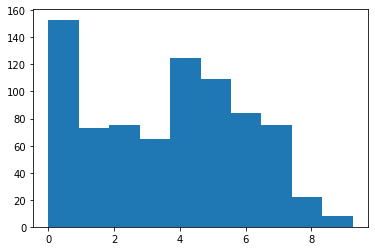

In [147]:
plt.hist(np.log(df_artist.total_days)) 
plt.title('log(total days artists are on the charts)')
plt.xlabel('log(total days on the charts)')
plt.ylabel('frequency of artists')
plt.show()

* We now use __hypothesis tests__ to see if there are significant differences in median audio feature values between the top 100 most popular artists (more popular) and the bottom 100 least popular (less popular) artists:

* We run two-sample hypothesis tests on the median audio feature values to see if the more popular artists' songs are different from the less popular artists' songs. For example, suppose we want to run a test on median tempo:
    * Let $med\_temp_{i}$ denote the median tempo of the $i^{th}$ artists' songs.
    * Let $\bar{TEMP}_{k}$ denote the median tempo of artists' songs in the $k^{th}$ averaged across all artists in that group. Let $k=1$ be the group containing the top 100 artists, and $k=2$ be the group containing the bottom 100 artists.
    * Similarly, let $s_{k}$ denote the standard deviation for the $k^{th}$ group, and let $n_k$ denote the number of artists in the $k^{th}$ group
    * Then:
        * $H_0: \bar{TEMP_{1}} = \bar{TEMP}_{2}$
        * $H_1: \bar{TEMP}_{1} \neq \bar{TEMP}_{2}$
        * $T = \frac{\bar{TEMP_{1}} - \bar{TEMP}_{2}}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}$  
    
* This is the general form each test will take. Since we are running 8 simultaneous tests (1 for each audio feature) at $\alpha = .05$, we need to control the false-positive rate. To do this, we will apply a simple __Bonferroni correction__ such that $\alpha_{adjusted} = .05/8 = 0.00625$

In [145]:
# split artist dataset into top 100 vs bottom 100
top100 = df_artist.sort_values(by = 'total_days', ascending = False).iloc[:100, :]
bot100 = df_artist.sort_values(by = 'total_days', ascending = True).iloc[:100, :]
alpha = .05/8 # adj-pvalue
print(f"bonferroni-corrected alpha = .05/8 = {alpha}\n")

# perform 2-sample t-test with unequal variances on each audio feature
for col in top100.columns[2:]: # for each audio feature
    print(f"difference in... average {col}") # test name
    print(f"\th0: Group 1 average {col} == Group 2 average {col}") # H0
    print(f"\th1: Group 1 average {col} != Group 2 average {col}\n") # HA
    print(f"\tGroup 1: {top100[col].mean()}\t\t\t Group 2:{bot100[col].mean()}") # point estimates
    tt = ttest_ind(top100[col], bot100[col], equal_var = False) # perform 2-sample t-test (w/ unequal var)
    print(f"\tt = {tt[0]}") # test statistic
    print(f"\tp = {tt[1]}") # p-value
    print(f"\tsignificant: {tt[1]<=alpha}\n") # check if p-value is less than or equal to Bonferonni-adj alpha level

bonferroni-corrected alpha = .05/8 = 0.00625

difference in... average median_danceability
	h0: Group 1 average median_danceability == Group 2 average median_danceability
	h1: Group 1 average median_danceability != Group 2 average median_danceability

	Group 1: 0.7056749999999999			 Group 2:0.6379500000000001
	t = 3.9095841541689205
	p = 0.00013558167382297904
	significant: True

difference in... average median_energy
	h0: Group 1 average median_energy == Group 2 average median_energy
	h1: Group 1 average median_energy != Group 2 average median_energy

	Group 1: 0.6184350000000001			 Group 2:0.6690200000000002
	t = -2.575979759702809
	p = 0.01095289607509198
	significant: False

difference in... average median_loudness
	h0: Group 1 average median_loudness == Group 2 average median_loudness
	h1: Group 1 average median_loudness != Group 2 average median_loudness

	Group 1: -6.385944999999997			 Group 2:-6.588709999999996
	t = 0.6704547412280895
	p = 0.5035674002559152
	significant: False

* We see the tests on __differences in median danceability, acousticness, liveness, and valence of songs by the top 100 most popular artists (denoted as Group 1) are significantly different than those of songs by the bottom 100 artists (denoted as Group 2)__. Specifically:
    * Group 1 average median danceability > Group 2 average median danceability: Group 1 songs are significantly more dance-able/catchy/rhythmic 
    * Group 1 average median speechiness > Group 2 average median speechiness: Group 1 songs are significantly more wordy

* These findings make a lot of sense: songs will stay on the charts longer if they are more danceable/catchy, as people will listen to them over and over again. Additionally, these songs will be streamed on the radio and at parties/social gatherings more frequently, boosting those songs' popularity. As for speechiness, this also makes sense: in the past few years, rap songs have become quite mainstream, and those songs tend to be pretty wordy.

* This is pretty interesting: songs by the more popular artists tend to be different in danceability and speechiness thant hose created by the less popular artists.

* Let's dig into the above results a bit more and generalize the comparisons to all artists in the dataset. 


* __We use k-means clustering to group together similar artists based on their median audio feature values__ and examine the distribution of clusters in the entire artists dataset compared to the distribution of clusters in the top 100 most popular artist list. 

* We start off with some __exploratory data analysis__: since we know there are some significant differences between songs by the most popular artists and songs by the least (relatively) popular artists, let's see if we can group together the artists by their typical musical features. This will help illustrate which artists tend to produce similar songs and help us find distinct patterns between artists' songs.

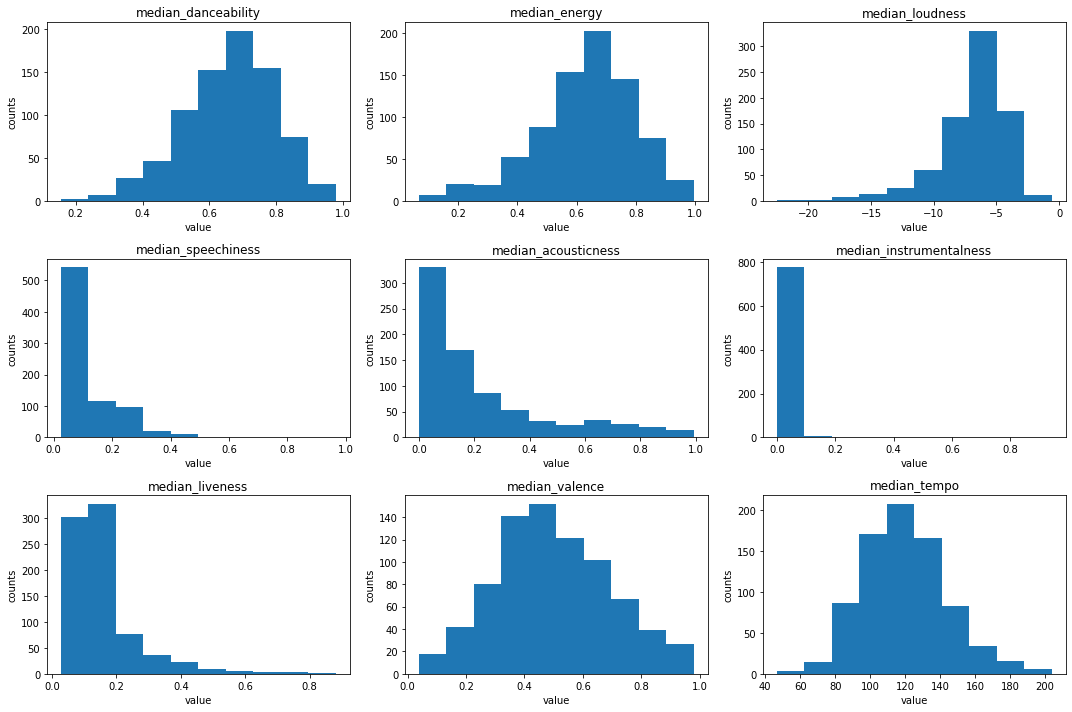

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15,10)) # 3x3 grid of distribution of median values for each feature by artist

for i, ax in enumerate(axes.flat):
    col = "median_" + cont_cols[i]
    ax.set_title(col)
    ax.hist(df_artist[col])
    ax.set_xlabel('value')
    ax.set_ylabel('count of artists')

fig.tight_layout()

plt.show()

* Since the majority of values for instrumentalness is 0, it won't be helpful in very discriminatory in clustering, so let's drop it from the dataset again.

In [18]:
df_artist.drop(columns = ['median_instrumentalness'], inplace = True) # drop instrumentalness

* Since the audio features are on difference scales (ex: tempo is usually around 100 - 150 while valence is between 0 and 1), we don't want any single feature to bias the clustering results. So, let's __rescale the features__.

In [20]:
cluster_cols = df_artist.columns[2:]
print('Features to be clustered on:', cluster_cols)

Index(['median_danceability', 'median_energy', 'median_loudness',
       'median_speechiness', 'median_acousticness', 'median_liveness',
       'median_valence', 'median_tempo'],
      dtype='object')

In [23]:
X = df_artist[cluster_cols] # values to be clustered on

Let's use the RobustScaler method to decrease the impact of outliers. The following describes how RobustScaler works:  
* Let $C$ be the column to be rescaled and $q_x$ be the $x^{th}$ quantile of $C$:
    * For each $c_i$ in $C$:
        * $c_{i,scaled} = \frac{c_i - median(C)}{q_{75} - q_{25})}$

In [24]:
def scale(X):
    """
    inputs:   X: dataframe with columns of continuous features to be scaled
    
    returns:  X_scaled: dataframe with scaled columns
    """
    X_scaled = X.copy()    
    scaled_values = RobustScaler().fit_transform(X)
    
    for i in range(scaled_values.shape[1]):
        X_scaled.iloc[:,i] = scaled_values[:,i]

    return X_scaled

In [25]:
X_scaled = scale(X) # return our dataframe with scaled columns

* To help us visualize this in 2D and to ameliorate the curse of dimensionality, let's __apply PCA to the scaled values using two components:__

In [26]:
def apply_pca(X, n):
    """
    inputs:   X: dataframe with scaled columns
              n: number of desired PCA components
              
    returns:  X_pca: copy of X with n PCA columns appended
    """
    pca = PCA(n_components=n)
    pc_cols = pd.DataFrame(pca.fit_transform(X), columns = [f"pc{i+1}" for i in range(n)])
    X_pca = pd.concat([X, pc_cols], axis = 1)        
    return X_pca

In [27]:
X_pca = apply_pca(X_scaled, 2) # return scaled dataframe with two PCA columns appended

* Now that features have been scaled and PCA values have been created, __we are ready to cluster the artists__:

In [29]:
def choose_k(X, cols, fewest):
    """
    performs k-means clustering such that smallest cluster has at least "fewest" artists
    
    inputs:   X: dataframe with scaled columns 
              cols: columns on which clustering is to be performed
              fewest: smallest allowable cluster size
    
    returns:  out: dictionary {k: number of clusters, labels: cluster assignments, min_artists: size of smallest cluster}
    """

    df = X.loc[:,cols]
    
    ins = [] #inertias
    prev_labels = None
    min_artists = []
    k = 1
    
    while len(min_artists) == 0 or min_artists[-1] >= fewest:    
        #keep clustering while the size of the smallest cluster > specified minimum
        
        k += 1
        km = KMeans(n_clusters = k)
        km.fit(df)
        labels = pd.Series(km.labels_)
        cnt = labels.value_counts().min() #size of smallest cluster; ensure that this >= fewest


        if cnt < fewest:
            #if clustering with k clusters results in a cluster that is smaller than allowed, break out of the loop and 
            #return the data corresponding to k-1 clusters
            out = {'k':k-1, 'labels': prev_labels, 'min_artists': min_artists[-1]}
            break
        else: #update stored data, keep going
            min_artists.append(cnt)
            prev_labels = labels
            ins.append(km.inertia_)    
            
        
    xaxis = range(2, k)
    plt.plot(xaxis, ins, marker = 'x')
    plt.xticks(xaxis)
    plt.xlabel("clusters")
    plt.ylabel("inertia")
    plt.show()
    
    plt.plot(xaxis, min_artists, marker = 'x', label = 'smallest size')
    plt.plot(xaxis, np.array(min_artists)/np.array(xaxis), marker = 'o',label = 'avg size')
    plt.xticks(xaxis)
    plt.xlabel("clusters")
    plt.ylabel("cluster size")
    plt.legend()
    plt.show()
    
    return out

* When using k-means clustering, we generally seek to pick $k$ to be the number of clusters corresponding to the "elbow" in the plot to reduce overfitting while still sufficiently reducing the within-group sum of squares.   


* However, our approach for clustering in the context of this project is a bit different: since there are so many genres and sub-genres that artists can fall under, we want my clustering results to capture this granularity, which is why we did not choose k to be the "elbow" of the plot. __TL;DR: we overfit our model in order to capture all of the unique genres our artists can fall into__.


* That being said, we did not want to have dozens of clusters containing only a few artists, so we included a parameter in the clustering function to __allow the user to specify the fewest number of artists any cluster is allowed to have__. So, the above function increments $k$, runs k-means with $k$ clusters, and checks how many artists are in the smallest cluster. It returns $k$ and a vector of labels such that running k-means with $k$ clusters results in the smallest cluster size being greater than or equal to the minimum allowed cluster size, while running k-means with $k+1$ clusters results in fewer artists than allowed. 

*Note that running the function multiple times will give different results since cluster assignments are random.*

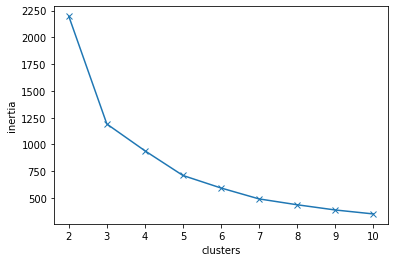

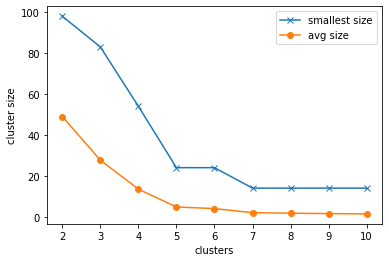

In [34]:
km_data = choose_k(X_pca, ['pc1', 'pc2'], 10) # run k-means clustering on our scaled dataframe s.t. smallest cluster has 10 artists

* In the above function call, we specified that the smallest cluster must have at least 10 artists (arbitrarily chosen). The first graph shows the inertia (sum of squared distances of points to their closest cluster center) for $1,...,k$ clusters, which the second graph shows the size of the smallest cluster for $1,...,k$ clusters.

In [35]:
k, labels, _ = km_data.values()

In [36]:
k #chosen k

10

In [37]:
labels.value_counts() #size of each cluster

8    193
1    168
7     98
3     96
9     68
0     62
6     41
5     31
2     18
4     14
dtype: int64

In [38]:
X_cluster = X_pca.copy()
X_cluster['cluster'] = labels

* Our scaled values aren't easily interpretable, so we revert back to the original values and attach the artists' labels:

In [39]:
df_clustered =df_artist.copy()
df_clustered['cluster'] = labels
df_clustered.head() # examine first five rows in our dataframe

,artist,total_days,median_danceability,median_energy,median_loudness,median_speechiness,median_acousticness,median_liveness,median_valence,median_tempo,cluster
0,Migos,3227.0,0.8365,0.6690,-5.6810,0.15400,0.07950,0.1325,0.3505,137.4800,1
1,Drake,6877.0,0.7200,0.5370,-7.7055,0.17350,0.11600,0.1225,0.3525,118.9900,8
2,The Weeknd,2926.0,0.5600,0.6110,-7.0150,0.06410,0.13100,0.1250,0.2520,119.8290,8
3,The Chainsmokers,2577.0,0.6160,0.6285,-6.6005,0.04265,0.05865,0.1505,0.3980,104.4755,3
4,Rae Sremmurd,1147.0,0.8030,0.6320,-5.1930,0.06490,0.05440,0.1110,0.2640,131.9860,1


In [40]:
def plot_clusters(df_labeled, k):
    """
    inputs:   df_labeled: dataframe with cluster assignments
              k: total number of clusters
    
    returns:  None (creates and shows scatterplot of cluster assignments)
    """
    for i in range(k):
        pts = df_labeled.loc[df_labeled.cluster == i, :]
        plt.scatter(pts["pc1"], pts["pc2"], label = i)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title = 'cluster',  bbox_to_anchor=(1.2, 1.0))
    plt.show()

Here's a plot showing the results of the clustering where each color represents a different cluster

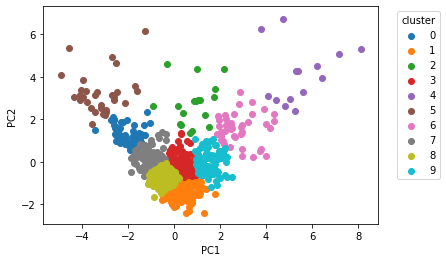

In [41]:
plot_clusters(X_cluster, k) # run plot_clusters function on our data w/ k = 10 clusters

* We can see our model overfitting, but again, this is the sacrifice we make to ensure we capture the true genres of each artist.

* Since clustering results are random (labels assigned are arbitrary -- while the artist groupings are relatively consistent, the labels change each time you run the clustering algorithm), let's save the dataframe and perserve our findings.

In [42]:
df_clustered.to_csv("data/TopCharts_clustered_artists.csv", index = False) # write to CSV

In [43]:
def top_artists(df, k, n):
    """
    gives top n most popular artists in each cluster
    
    inputs:   df: dataframe with cluster assignments
              k: total number of clusters
              n: how many artists to show in each cluster    
    returns:  d: dictionary {cluster number: list of artists}
    """
    d = dict()
    for i in range(k):
        subset = df.loc[df.cluster == i, :].sort_values(by = "total_days", ascending = False)
        d[i] = list(subset.artist[:min(n, len(subset))])
    return d

* These are the top 5 most popular artists in each cluster, as determined by the total number of days their songs were on the charts:

In [44]:
pp.pprint(top_artists(df_clustered, 10, 5))

{   0: ['Billie Eilish', 'Sam Smith', 'Joji', '6LACK', 'Lewis Capaldi'],
    1: ['Migos', 'Marshmello', 'Logic', 'DaBaby', '6ix9ine'],
    2: ['Lord Huron', 'Brenda Lee', 'Wham!', 'José Feliciano', 'The Jackson 5'],
    3: [   'Lil Uzi Vert',
           'Travis Scott',
           'Kendrick Lamar',
           'The Chainsmokers',
           'Future'],
    4: ['Steve Aoki', 'John Lennon', 'Skrillex', 'Powfu', 'FRENSHIP'],
    5: [   'Bing Crosby',
           'Frank Sinatra',
           'Nat King Cole',
           'Dean Martin',
           'Jeremy Zucker'],
    6: ['Lizzo', 'Famous Dex', 'Dustin Lynch', 'Lunay', 'Louis Tomlinson'],
    7: ['XXXTENTACION', 'Khalid', 'J. Cole', 'Lauv', 'Offset'],
    8: ['Post Malone', 'Drake', 'Juice WRLD', 'Ariana Grande', 'Ed Sheeran'],
    9: ['Luke Combs', 'Eminem', 'DJ Khaled', 'Panic! At The Disco', 'KYLE']}


* For each cluster, let's examine the mean and median number of total days spent on the charts by the artists in that cluster:

In [141]:
for i in range(k): # for each cluster
    days = df_clustered.loc[df_clustered.cluster == i, 'total_days']
    print(f"cluster {i}:\n\taverage days: {days.mean()}\n\tmedian days: {days.median()}")

cluster 0:
	average days: 174.80645161290323
	median days: 8.0
cluster 1:
	average days: 205.9345238095238
	median days: 50.5
cluster 2:
	average days: 40.44444444444444
	median days: 14.5
cluster 3:
	average days: 389.9166666666667
	median days: 86.0
cluster 4:
	average days: 31.714285714285715
	median days: 7.5
cluster 5:
	average days: 61.03225806451613
	median days: 34.0
cluster 6:
	average days: 71.46341463414635
	median days: 17.0
cluster 7:
	average days: 300.7959183673469
	median days: 52.5
cluster 8:
	average days: 547.2331606217616
	median days: 86.0
cluster 9:
	average days: 179.83823529411765
	median days: 67.0


* Clearly, __artists in clusters 3 and 8 seem to spend more days on the charts than artists in other clusters__. Is this reflected in the distribution of clusters in the top 100 artists? Let's narrow our scope and develop these findings further:

* __Representation of clusters in top 100 most popular artists:__
let's see if there are any clusters that are over/under-represented in the top 100 most popular artists:

In [45]:
def plot_cluster_barchart(subset_cnts, subset_name, k, compare, baseline_props = None):
    """
    plots cluster proportions
    
    inputs: subset_cnts: cluster frequencies in subset 
            subset_name: name of subset
            k: total number of clusters
            compare: True if want to compare to baseline proportions, else False
            baseline_props: baseline proportions for comparison
    
    returns: subset_heights: cluster proportions in subset
    """
    xaxis = np.array(range(k))
    
    n = sum(subset_cnts.values)
    subset_heights = [subset_cnts[i]/n if i in subset_cnts.index else 0 for i in range(k)]
    
    plt.bar(xaxis, subset_heights, .4, label = subset_name)
    plt.xlabel("cluster")
    plt.ylabel("prop")
    if compare:
        plt.bar(xaxis+.4,baseline_props, .4, color='r',label='all')
        plt.legend()
        plt.xticks(xaxis+.4/2, xaxis)
    else:
        plt.xticks(xaxis)
    plt.show()
    
    return subset_heights


In [46]:
size_all = len(df_artist)
all_cnts = df_clustered.cluster.value_counts()
print("proportion of artists in each cluster:")
for i in range(10):
    print(f"\tcluster {i}: {round(all_cnts[i]/size_all, 4)}")

proportion of artists in each cluster:
	cluster 0: 0.0786
	cluster 1: 0.2129
	cluster 2: 0.0228
	cluster 3: 0.1217
	cluster 4: 0.0177
	cluster 5: 0.0393
	cluster 6: 0.052
	cluster 7: 0.1242
	cluster 8: 0.2446
	cluster 9: 0.0862


* These are the proportions we would expect to see. For example, if we were to take a sample of 100 artists out of all artists in the dataset, we would expect ~7 of them to belong to cluster 0.

* Distribution of clusters in entire dataset: 

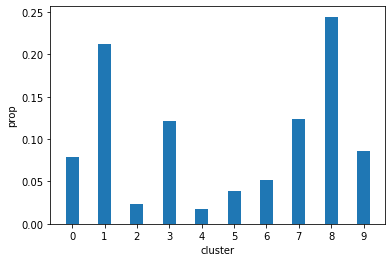

In [47]:
all_props = plot_cluster_barchart(df_clustered.cluster.value_counts(), "all", 10, False)

In [142]:
t100 = df_clustered.sort_values(by = 'total_days', ascending = False).iloc[:100, :]
t100_cnts = t100.cluster.value_counts()
t100_cnts

8    51
3    15
1    14
7     9
9     5
0     4
6     2
Name: cluster, dtype: int64

* Raw counts of clusters in top 100 artists. 51 of the top 100 artists are in cluster 8, 15 are in cluster 3, and so forth.

* Distribution of clusters proportions among top 100 artists:

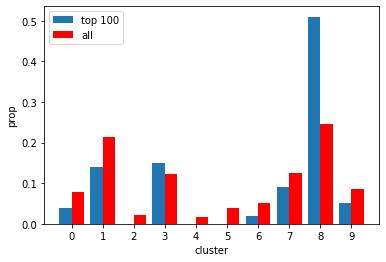

In [51]:
t100_props = plot_cluster_barchart(t100_cnts, "top 100", 10, True, all_props)

__In the top 100 artists, it looks like cluster 8 is extremely overrepresented (with the largest absolute difference in proportions being ~0.25) while the other clusters (except for cluster 3) seem to be underrepresented__. To validate our hypothesis that the observed distribution of clusters in the top 100 artists is different from the expected distribution, let's run a Chi Squared Goodness of Fit test as formal verification.

The hypotheses we will be testing are:
* $H_0:$ these observations are consistent with the expected distribution of cluster frequencies
* $H_1:$ these observations are NOT consistent with the expected distribution of cluster frequencies

In [55]:
def gof_test(subset_cnts, all_cnts, k, verbose = True):
    """
    performs chi-squared goodness of fit test
    
    inputs: subset_cnts: cluster frequencies in subset 
            all_cnts: cluster frequencies in entire dataset
            k: total number of clusters
            verbose: True if chi-squared stat, p-value, and test results to be printed, False if not
    
    returns: (chisq, p): chi-squared test statistic and corresponding p-value
    """
    
    n_sub = sum(subset_cnts.values)
    n_all = sum(all_cnts.values)
    
    observed_counts = np.array([subset_cnts[i] if i in subset_cnts.index else 0 for i in range(k)])
    expected_counts = np.array([all_cnts[i] * (n_sub/n_all) if i in all_cnts.index else 0 for i in range(k)])
    chisq, p = chisquare(observed_counts, f_exp=expected_counts)
    rej = "Yes" if p<.05 else "No"
    if verbose:
        print(f"Chisq: {chisq}\t\t Pr(>Chisq): {p}")
        print(f"Reject null?: {rej}")
    return chisq, p

In [56]:
t100_chisq, t100_p = gof_test(t100_cnts, all_cnts, 10) # run our GOF test

Chisq: 46.25617072397899		 Pr(>Chisq): 5.397277684535313e-07
Reject null?: Yes


* It looks like our intuitions from looking at the distributions were correct: the distribution of cluster frequencies in the top 100 most popular artists does not match the expected frequencies. 


* However, something else to consider is how likely it is for us to have gotten our results due to sheer chance. So, let's run some simulations to empirically determine how likely or unlikely our previous results are.

__Simulation analysis of the goodness-of-fit test results and conclusions:__

In [59]:
def sim_cluster_dist(cluster_df, n_iter, k):
    """
    performs simulation of cluster proportions; randomly chooses 100 artists from the entire dataset 
    and performs goodness of fit test
    
    inputs: cluster_df: entire dataset with cluster assignments
            n_iter: number of simulations to run
            k: total number of clusters
    returns: chisq_list: list of chi-squared test statistics from goodness of fit test (1 for each simulation)
             p_list: list of p-values, corresponds to chisq_list
             sim_props: cluster proportions in across all simulations
    """
    sim_cnts = np.zeros(k)
    p_list = []
    chisq_list = []
    n = len(cluster_df)
    for i in range(n_iter):
        idx = np.random.choice(range(n), 100, replace = False)
        vc = cluster_df.loc[idx, 'cluster'].value_counts()
        for c in vc.index:
            sim_cnts[c] += vc[c]
        x,p = gof_test(vc, all_cnts, k, verbose = False)
        chisq_list.append(x)
        p_list.append(p)
    
    sim_props = plot_cluster_barchart(pd.Series(sim_cnts), "simulated", k, True, all_props)
    return chisq_list, p_list, sim_props

Let's run 1000 simulations of 100 random samples from the entire artist dataset.

This histogram shows the proportion of clusters across all 1000 simulations of 100 samples. We can see that it almost perfectly matches the expected proportions.

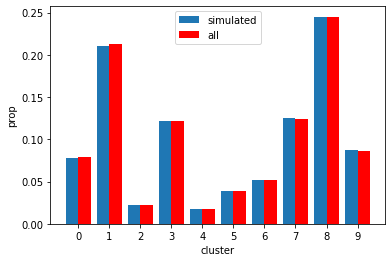

In [60]:
sim_data = sim_cluster_dist(df_clustered, 1000, 10)

We can see that 27 Type I errors (incorrectly rejecting the null hypothesis) have been made in 1000 simulations. Without even taking into considering the magnitude of our p-value for the goodness of fit test on the top 100 artists, we can see that our findings are already quite unlikely: there is only a 2.7% chance for our findings to have been a result of sheer chance.

In [61]:
print(f"number of times where the goodness of fit test rejects h0: {len(np.where(np.array(sim_data[1])<.05)[0])}")

number of times where the goodness of fit test rejects h0: 27


Now, let's take into consideration the magnitude of our findings by looking at the distribution of $\chi^2$ statistics in the simulation

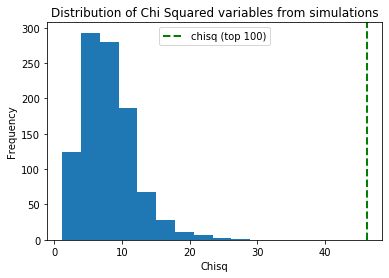

In [143]:
plt.hist(sim_data[0])
plt.axvline(x =t100_chisq, color = 'g', linestyle = 'dashed', linewidth = 2, label = 'chisq (top 100)')
plt.title("Distribution of Chi Squared variables from simulations")
plt.xlabel("Chisq")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [144]:
print(f"number of simulated chisq variable > chisq variable for top 100: {len(np.where(np.array(sim_data[0])>t100_chisq)[0])}")

number of simulated chisq variable > chisq variable for top 100: 0


This histogram shows the distribution of goodness of fit $\chi^2$ statistics from the simulation (for example, there are ~300 simulated $\chi^2$ variables around 5). 

In the above output, we can see that not a single simulation out of the 1000 simulations we ran produced results remotely close to the $\chi^2$ statistic we observed for the top 100 artists. This means that it is extremely unlikely for our findings to be an artifact of randomness -- __the differences between the distributions of clusters in the top 100 artists and the overall dataset is very significant.__ 

So what does this mean? Since cluster assignments are determined each artist's median audio feature values, we can see the top 100 most popular artists have median audio feature values that make them more likely to be put in cluster 8. Because ~1/2 of the top 100 artists are in cluster 8, which we previously showed to be significantly more than expected, __we can conclude that there is a subset of features that is indicative of how likely the artist is to be in the top 100 list.__

Without multiple testing methods, we aren't able to definitively tell what these features are, but let's take a look at the distribution of features in each cluster anyways.

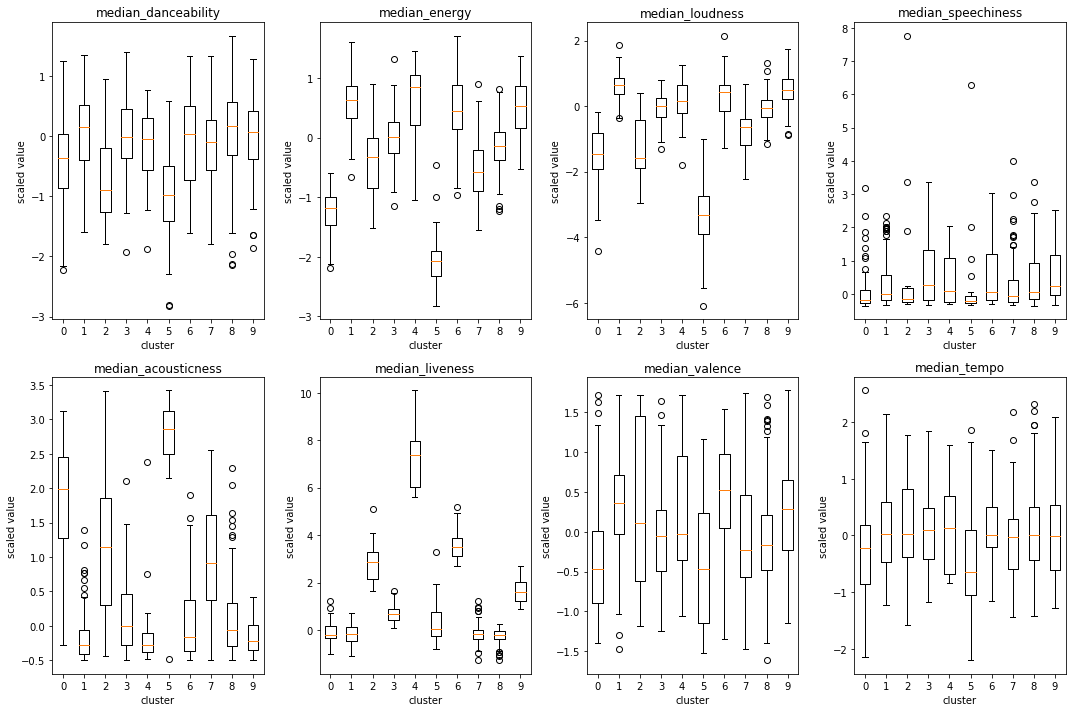

In [140]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,10))

for i, ax in enumerate(axes.flat):
    col = cluster_cols[i]
    
    data = [X_cluster.loc[X_cluster.cluster == i, col] for i in range(k)]
    ax.boxplot(data)
    ax.set_xlabel("cluster")
    ax.set_ylabel("scaled value")
    ax.set_xticklabels(list(range(k)))
    ax.set_title(col)

fig.tight_layout()

plt.show()

From the above boxplots, without doing multiple testing, it's hard to tell exactly what makes cluster 8 different (and consequently, what subset of features is related to the probability of an artist being in the top 100). 

Nonetheless, 

In [117]:
LinearRegression().fit(df_artist.iloc[:,2:], np.log(df_artist.total_days)).score(df_artist.iloc[:,2:],np.log(df_artist.total_days))

0.0764388413764523

# Statistical Modeling: does the probability of a #1 song change if an artist already has one?

We move on from clustering songs and artists to address an interesting question: does the probability of a number 1 song change if an artist already has one? That is, if an artist has already produced a top song, is it more probable that their next song reaches the top spot as compared to a different artist?

In [75]:
print('Number of different artists with a #1 song:', len(all_df.artist[all_df['rank']==1].unique()))
print('Total number of artists included in dataset:', len(all_df.artist.unique()))
print('\nProportion of artists in dataset with a #1 song:', len(all_df.artist[all_df['rank']==1].unique())/len(all_df.artist.unique()))

Number of different artists with a #1 song: 40
Total number of artists included in dataset: 789

Proportion of artists in dataset with a #1 song: 0.050697084917617236


Wow, very few artists -- only around five percent -- have a number one song! This is not too surprising, however, since it feels like the same artists seem to appear over and over in the number one song position (e.g., Drake, Post Malone, etc.). Keep in mind that this dataset only includes songs and artists that reach the top 200 -- I can only imagine how small the proportion of __ALL__ artists that reach the number one song position must be.

Now, let's examine the breakdown of number one songs by artist:

In [76]:
num_one_df = all_df.loc[all_df['rank'] == 1, :].drop_duplicates(subset = 'uri') # only keep #1 songs
num_one_pt = num_one_df.pivot_table(columns = 'artist', aggfunc = 'size') # table of #1 songs by artist
print("artist:\t\tnumber of rank 1 songs\n")
print(num_one_pt)

artist:		number of rank 1 songs

artist
21 Savage             1
Ariana Grande         4
Arizona Zervas        1
Billie Eilish         2
Childish Gambino      1
DJ Khaled             1
DaBaby                1
Drake                 7
Ed Sheeran            2
Eminem                1
French Montana        1
Harry Styles          1
J. Cole               2
Jonas Brothers        1
Juice WRLD            1
Kanye West            3
Kendrick Lamar        1
Kodak Black           1
Lil Baby              2
Lil Nas X             3
Lil Peep              1
Lil Tecca             1
Lil Uzi Vert          5
Lil Wayne             1
Logic                 2
Luis Fonsi            1
Mariah Carey          1
Migos                 1
NAV                   1
Post Malone           8
Roddy Ricch           1
Selena Gomez          1
Shawn Mendes          1
Sheck Wes             1
Taylor Swift          5
The Weeknd            3
Travis Scott          3
Tyler, The Creator    1
XXXTENTACION          2
Young Thug            1


We observe that only some of the biggest names in music have a number one song. It appears that artists with more than one number one song are in an even more exclusive group, as we can see that very few artists have more than one number one hit.

So, given that the artist has a number one song, just how many do they have in total?

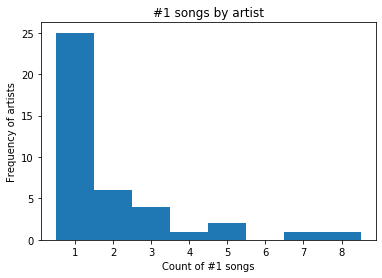

In [77]:
plt.hist(num_one_pt.values, bins = np.arange(0.5,9,1)) # better align our bins
plt.title('#1 songs by artist')
plt.xlabel('Count of #1 songs')
plt.ylabel('Frequency of artists')
plt.show()

We confirm that the number of artists with a particular count of number one songs decreases significantly for each additional number one song.

So, we now model the probability of an artist having a number one song after having one already -- let's try using the Geometric model supported on the set {1, 2, 3, ...} (since there is no clear maximum to the number of number one songs artists can have) with different parameters and maximize the log-likelihood.

In [78]:
def geom_ll(x, p_list):
    x = np.array(x)
    n = len(x) # n total observations
    p_list = [round(p, 8) for p in p_list]
    ## probability mass function of Geometric distribution: p(X=k) = p*(1-p)^(k-1)
    ll = [n*np.log(p) + np.log(1-p)*sum(x-1) for p in p_list] # log-likelihood corresponds to log(joint pmf)
    plt.xlabel('Success probability p')
    plt.ylabel('Log-likelihood')
    plt.show()
    return dict(zip(p_list, ll)), p_list[np.where(ll == max(ll))[0][0]]

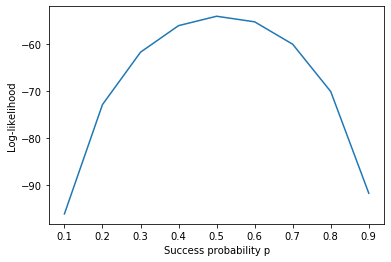

p's and corresponding loglikelihood values:
{   0.1: -96.10710331475921,
    0.2: -72.85697144730398,
    0.3: -61.71256004270928,
    0.4: -56.06300297807384,
    0.5: -54.06548008367574,
    0.6: -55.25207276185752,
    0.7: -60.01796432193486,
    0.8: -70.08438272506422,
    0.9: -91.7126541600868}

maximum likelihood estimation of p: 0.5


In [79]:
p_dict, p_maxll = geom_ll(num_one_pt.values, np.arange(.1, 1,.1))
print("p's and corresponding loglikelihood values:")
pp.pprint(p_dict)
print(f"\nmaximum likelihood estimation of p: {p_maxll}")

* We see that the log-likelihood using a Geometric model is maximized with success probability $p=0.5$. This model suggests that, __given an artist already has one song that has hit rank 1, the probability of having an additional rank 1 song comes down to approximately a coin flip.__

* We note that there are some downfalls with using this model, such as the *lack of independence between trials* (whether or not an artist will get another number one song). There is also a potential issue with *a non-constant probability of getting an additional number one song*. These issues arise due to the fact that more popular artists tend to accumulate number one songs with little difficulty, but newer, less popular artists have difficulty establishing themselves. Likewise, if an artist stops making music or puts out a very popular album, the probability of an additional number one song changes.

* Using the model, the fact that the probability an artist has an additional number one song after having at least one can simply come down to a coin flip is quite an interesting finding!

* Thus, since the probability of an artist having another number one song (after having one already) is approximately 0.5 and since very few artists -- only around five percent -- have a number one song, __we conclude that the probability of an artist having a number one song if they already have one is about ten times greater than if they don't.__

# Statistical Modeling: does the probability of top 10 song change if an artist already has one?